In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

## Reading & Pre-Processing Bitcoin Data

In [52]:
df = pd.read_csv('Bitcoin.csv')
df['Date'] = pd.to_datetime(df.Date)
df = df.drop(['Unnamed: 2', 'Market Cap'], axis=1)
df.set_index('Date', inplace=True)
df = df.resample('D').mean()
df['Open'] = df['Open'].fillna(method='ffill')
df['High'] = df['High'].fillna(method='ffill')
df['Low'] = df['Low'].fillna(method='ffill')
df['Last price'] = df['Last price'].fillna(method='ffill')
df = df[df.index.year > 2019]
df.columns = ['last_price', 'open', 'high', 'low']
df.reset_index(inplace=True)

## Reading & Pre-Processing Indices Data

In [53]:
indices = pd.read_csv('Indices.csv')
indices.columns = ['Date','USD', 'RMB',
       'fed_fund_rate', 'FTSE100_euro', 'dow_jones_USD',
       'NFP_thousands']
indices = indices[indices['Date'].notna()]
indices['Date'] = pd.to_datetime(indices['Date'])
indices = indices.sort_values(by='Date', ascending=True).reset_index().drop('index', axis=1)

In [54]:
indices.head()

,Date,USD,RMB,fed_fund_rate,FTSE100_euro,dow_jones_USD,NFP_thousands
0,2016-08-05,96.194,2976.696,0.5,6793.47,18543.53,NaN
1,2016-08-08,96.401,3004.277,0.5,6809.13,18529.29,NaN
2,2016-08-09,96.183,3025.681,0.5,6851.30,18533.05,NaN
3,2016-08-10,95.650,3018.746,0.5,6866.42,18495.66,NaN
4,2016-08-11,95.857,3002.637,0.5,6914.71,18613.52,NaN


#### Checking null values

In [55]:
indices.isna().sum()

Date                0
USD                16
RMB               103
fed_fund_rate      64
FTSE100_euro       56
dow_jones_USD      62
NFP_thousands    1260
dtype: int64

#### Removing NFP Thousands Columns because mostly Null

In [56]:
indices = indices.drop('NFP_thousands', axis=1)
indices['USD'] = indices['USD'].fillna(method='ffill')
indices['RMB'] = indices['RMB'].fillna(method='ffill')
indices['fed_fund_rate'] = indices['fed_fund_rate'].fillna(method='ffill')
indices['FTSE100_euro'] = indices['FTSE100_euro'].fillna(method='ffill')
indices['dow_jones_USD'] = indices['dow_jones_USD'].fillna(method='ffill')

In [57]:
indices.head()

,Date,USD,RMB,fed_fund_rate,FTSE100_euro,dow_jones_USD
0,2016-08-05,96.194,2976.696,0.5,6793.47,18543.53
1,2016-08-08,96.401,3004.277,0.5,6809.13,18529.29
2,2016-08-09,96.183,3025.681,0.5,6851.30,18533.05
3,2016-08-10,95.650,3018.746,0.5,6866.42,18495.66
4,2016-08-11,95.857,3002.637,0.5,6914.71,18613.52


#### Merging Bitcoin Data with Indices data

In [58]:
df = df.merge(indices, on='Date', how='left')

df['USD'] = df['USD'].fillna(method='ffill')
df['RMB'] = df['RMB'].fillna(method='ffill')
df['fed_fund_rate'] = df['fed_fund_rate'].fillna(method='ffill')
df['FTSE100_euro'] = df['FTSE100_euro'].fillna(method='ffill')
df['dow_jones_USD'] = df['dow_jones_USD'].fillna(method='ffill')

df.set_index('Date', inplace=True)

In [59]:
df_train = df[df.index < '2021-07-01'].copy()

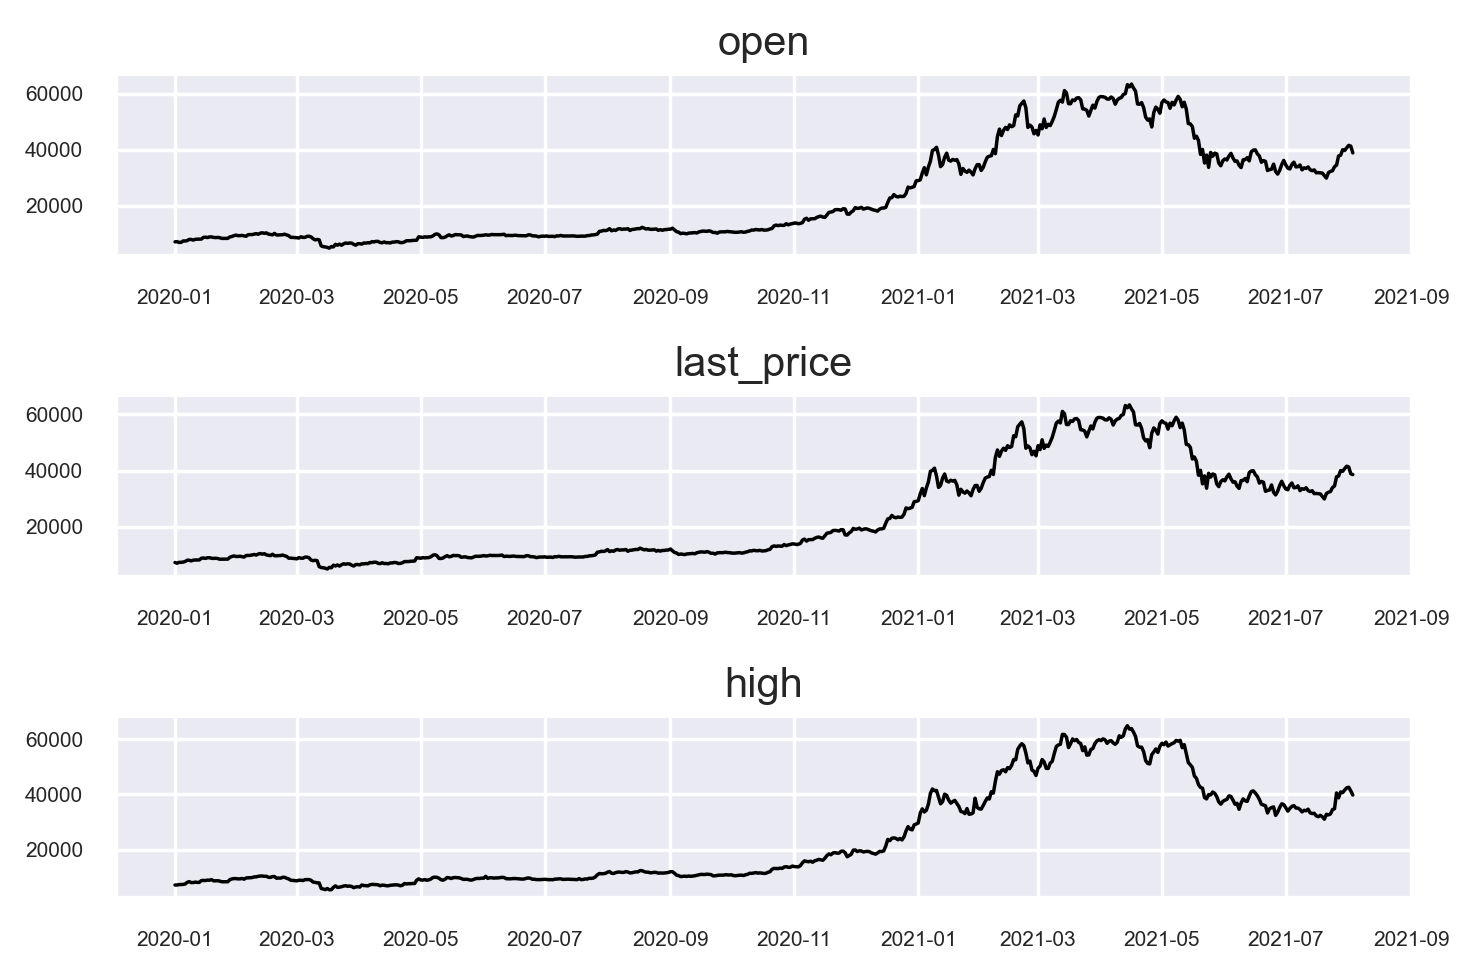

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, dpi=250)

ax1.plot(df['open'], color='black', linewidth=1)
ax1.set_title('open')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(df['last_price'], color='black', linewidth=1)
ax2.set_title('last_price')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

ax3.plot(df['high'], color='black', linewidth=1)
ax3.set_title('high')
ax3.xaxis.set_ticks_position('none')
ax3.yaxis.set_ticks_position('none')
ax3.spines['top'].set_alpha(0)
ax3.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

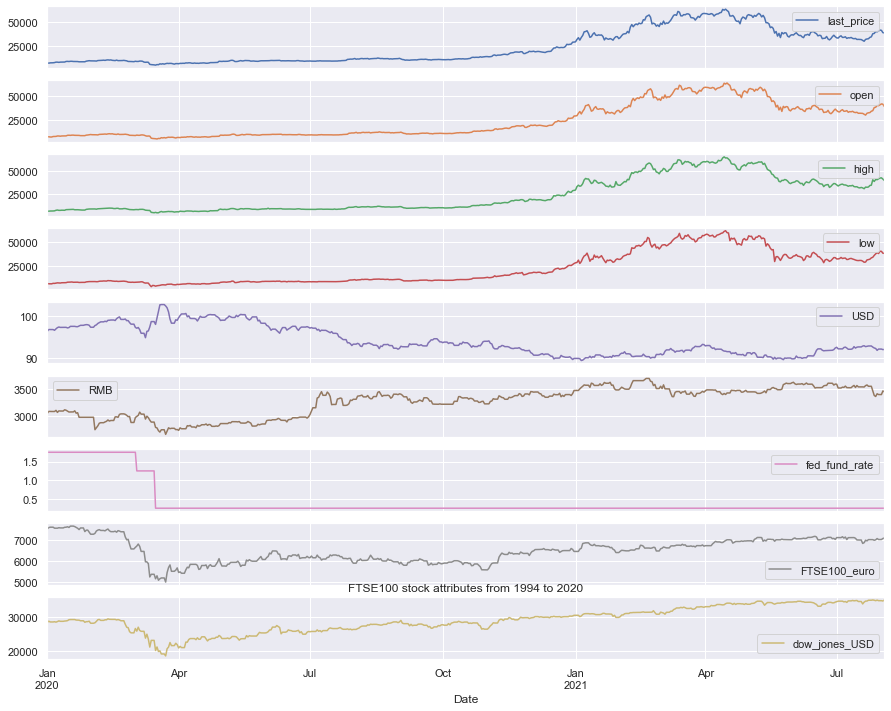

In [61]:
df.plot(subplots=True, figsize=(15,12))
plt.title('FTSE100 stock attributes from 1994 to 2020')
# plt.savefig('stocks.png')
plt.show()

In [62]:
df.columns

Index(['last_price', 'open', 'high', 'low', 'USD', 'RMB', 'fed_fund_rate',
       'FTSE100_euro', 'dow_jones_USD'],
      dtype='object')

## Feature Importance using XG Boost

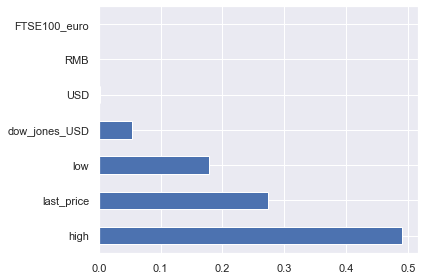

In [63]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(df_train[['last_price','high', 'low', 'USD', 'RMB', 'fed_fund_rate',
       'FTSE100_euro', 'dow_jones_USD']], df_train[['open']])

(pd.Series(model.feature_importances_, index=df_train[['last_price','high', 'low', 'USD', 'RMB', 'fed_fund_rate',
       'FTSE100_euro', 'dow_jones_USD']].columns)
   .nlargest(7)
   .plot(kind='barh'))

plt.tight_layout()
plt.show()

##### We eliminate low, high and last price to check what other features are important because these 3 are bound to have a good feature importance because of correlation

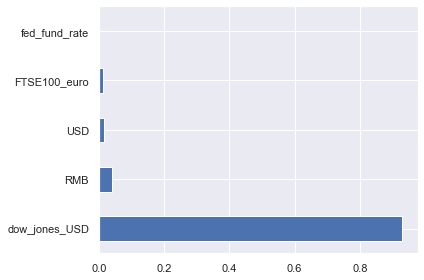

In [64]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(df_train[['USD', 'RMB', 'fed_fund_rate',
       'FTSE100_euro', 'dow_jones_USD']], df_train[['open']])

(pd.Series(model.feature_importances_, index=df_train[[ 'USD', 'RMB', 'fed_fund_rate',
       'FTSE100_euro', 'dow_jones_USD']].columns)
   .nlargest(7)
   .plot(kind='barh'))

plt.tight_layout()
plt.show()

### Final chosen feature

1. High
2. Low
3. Last Price
4. Dow Jones USD
5. RMB

In [65]:
endog = df_train[['open', 'high', 'low', 'last_price', 'dow_jones_USD','RMB']]

## Varma

> The function **optimize_Varma** return the results of a list of parameters on the given dataset

In [66]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding MSE
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        mse = model.mse
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

##### Selecting Data and Initializing p & q parameters

In [27]:
endog = df[['open', 'high', 'low', 'last_price', 'dow_jones_USD','RMB']]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

result_df_VARMA = optimize_VARMA(endog, parameters_list)
result_df_VARMA

  0%|          | 0/9 [00:00<?, ?it/s]

,"(p,q)",mse
0,"(1, 1)",5.007702e+06
1,"(1, 0)",5.270986e+06
2,"(2, 2)",5.343242e+06
3,"(2, 1)",5.356219e+06
4,"(2, 0)",5.359271e+06
5,"(1, 2)",5.531788e+06
6,"(0, 2)",1.833695e+08
7,"(0, 1)",4.060119e+08


In [67]:
best_model_VARMA = VARMAX(endog, order=(4,1))
res_VARMA = best_model_VARMA.fit(disp=False)
print(res_VARMA.summary())

                                                 Statespace Model Results                                                
Dep. Variable:     ['open', 'high', 'low', 'last_price', 'dow_jones_USD', 'RMB']   No. Observations:                  547
Model:                                                                VARMA(4,1)   Log Likelihood              -22487.692
                                                                     + intercept   AIC                          45389.384
Date:                                                           Tue, 05 Oct 2021   BIC                          46280.404
Time:                                                                   14:12:18   HQIC                         45737.663
Sample:                                                               01-01-2020                                         
                                                                    - 06-30-2021                                         
Covariance Type:        

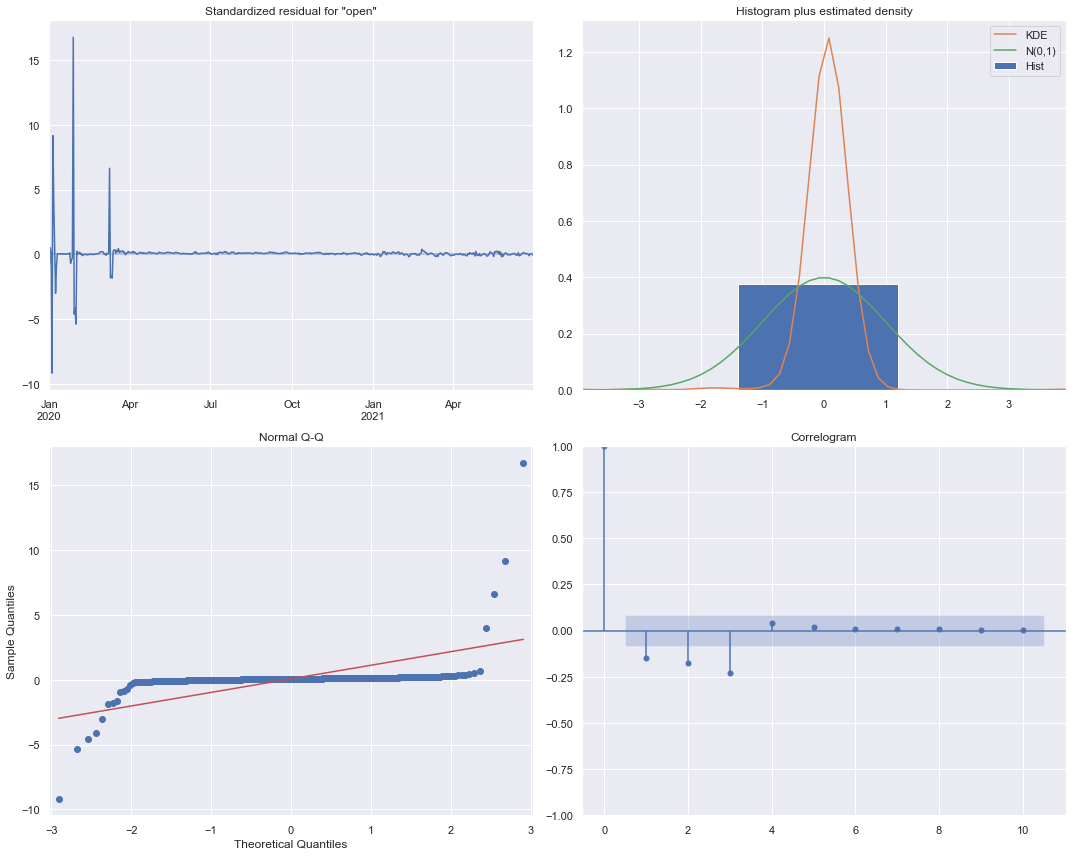

In [68]:
res_VARMA.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()

In [69]:
n_forecast = df[df.index >= '2021-07-01'].shape[0]
t1 = pd.to_datetime('2021-07-01')
t2 = pd.to_datetime('2021-08-03')

predict = res_VARMA.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
idx = np.arange(len(predict.predicted_mean))
pred_dynamic_ci = predict.conf_int(alpha=0.2)
true_vals = df[(df.index >= '2021-07-01')]

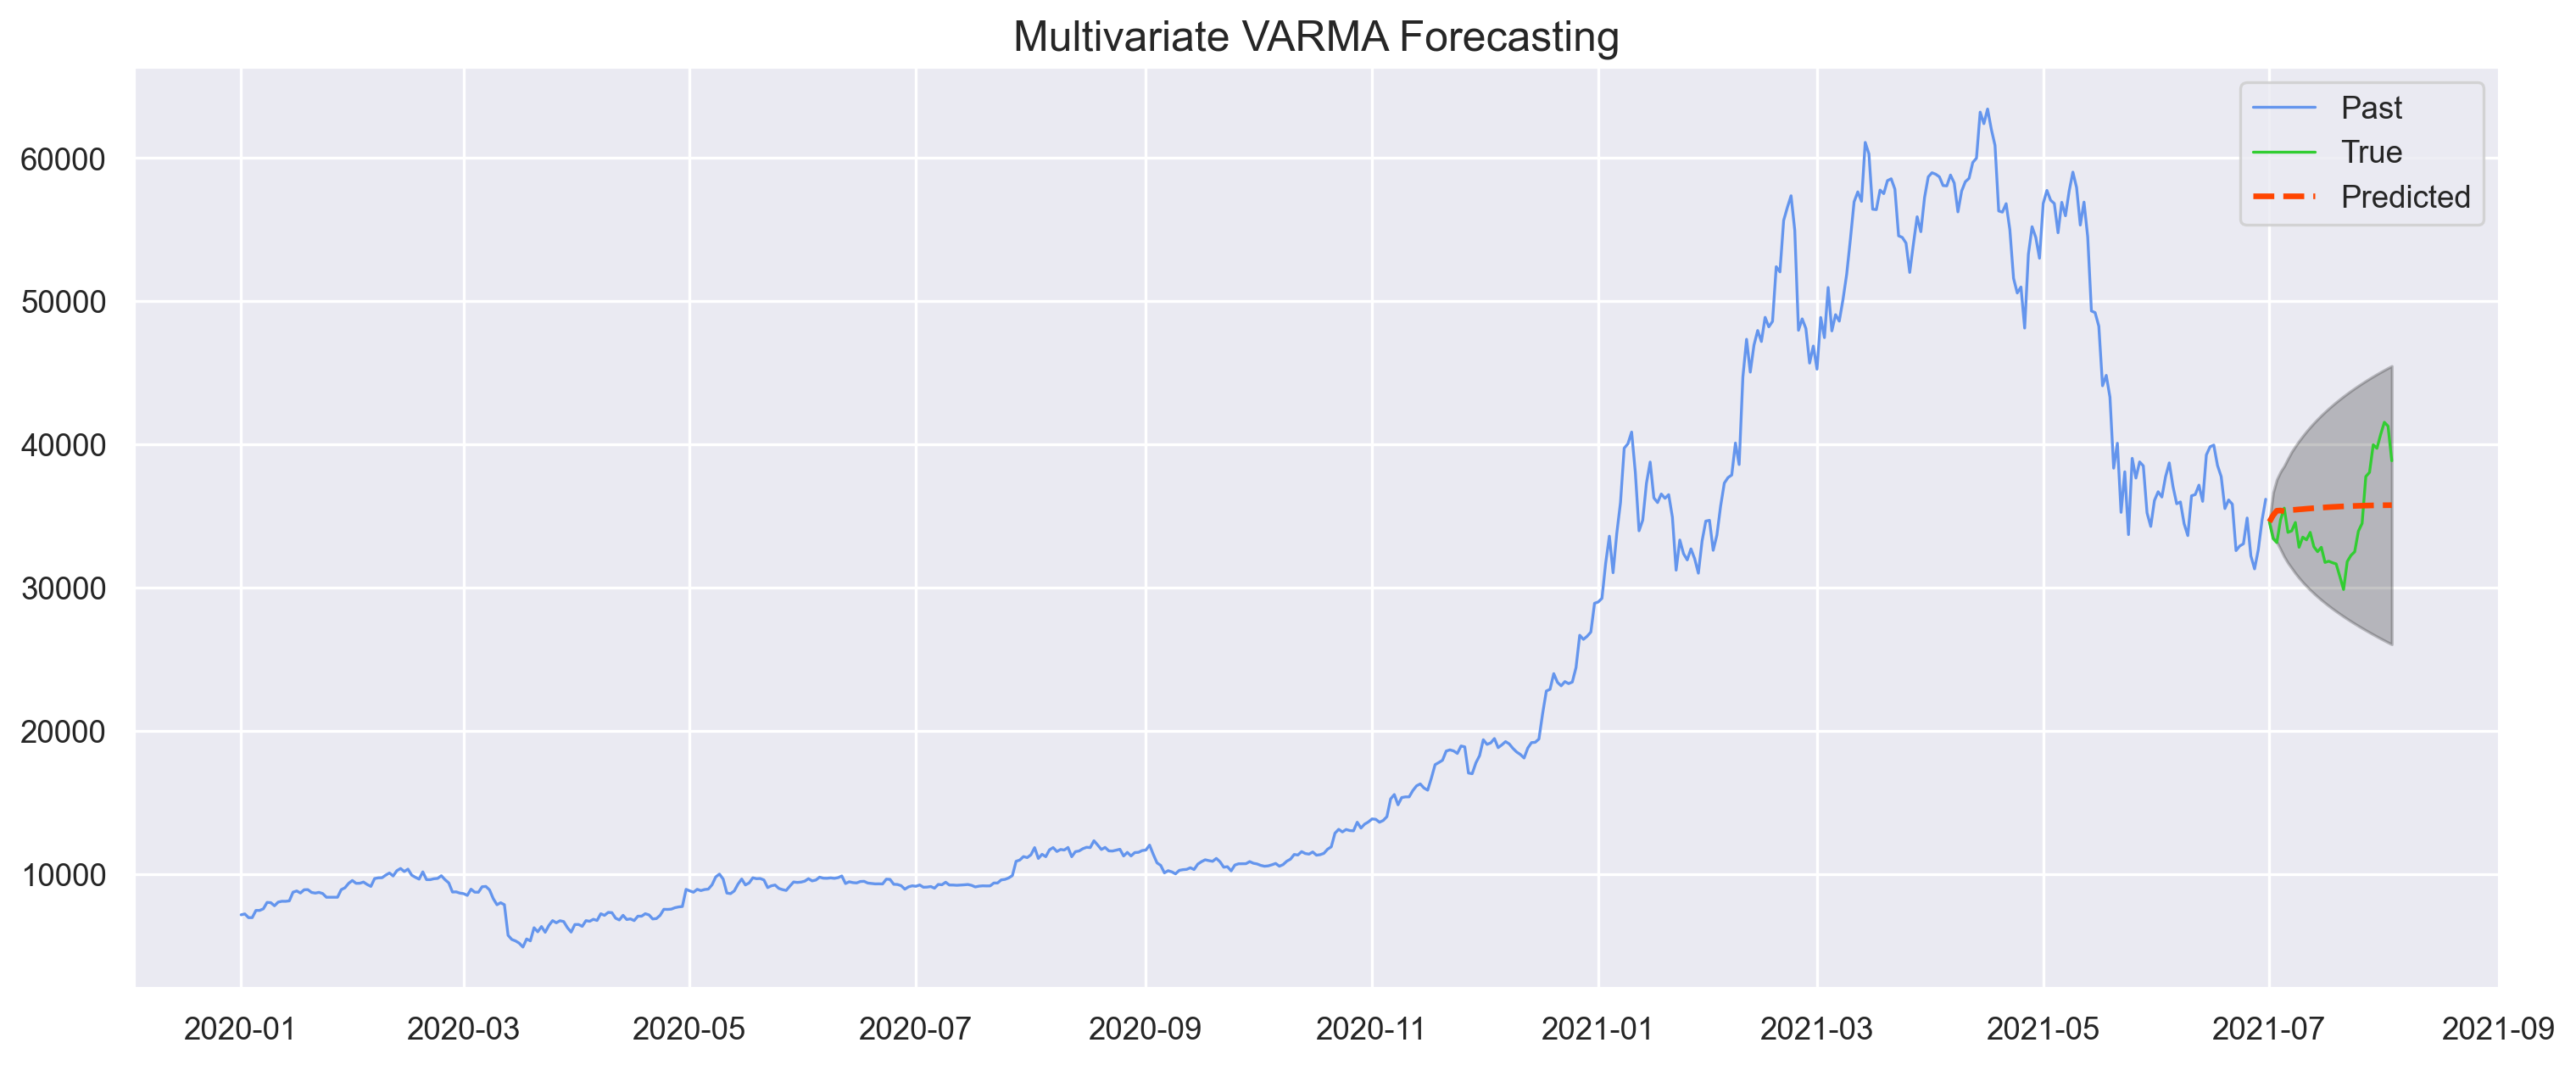

In [62]:
fig, ax1 = plt.subplots(dpi=240,figsize=(15,6))

ax1.plot(df_train['open'], color='cornflowerblue', linewidth=1, label='Past')
ax1.plot(true_vals['open'], color='limegreen', linewidth=1, label='True')


ax1.plot(predict.predicted_mean.index, 
         predict.predicted_mean['open'], 
         color='orangered', 
         ls='--',
         linewidth=2, label='Predicted')


ax1.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci['lower open'],
                pred_dynamic_ci['upper open'], color='k', alpha=.25)

# ax1.fill_between(macro_date_show.index, macro_date_show.ftselow, macro_date_show.ftsehigh, color='lightskyblue', alpha=0.5)
# ax1.fill_between(true_vals.index, true_vals.ftselow, true_vals.ftsehigh, color='lightgreen', alpha=0.5)

ax1.set_title("Multivariate VARMA Forecasting", size = 15)
ax1.legend()

plt.show()

## Prophet

In [16]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [17]:
df.reset_index(inplace=True)

In [18]:
df.columns = ['ds','last_price', 'y', 'high', 'low', 'USD', 'RMB', 'fed_fund_rate',
       'FTSE100_euro', 'dow_jones_USD']

In [19]:
df.head()

,ds,last_price,y,high,low,USD,RMB,fed_fund_rate,FTSE100_euro,dow_jones_USD
0,2020-01-01,7216.21,7158.22,7236.37,7151.89,96.445,3050.124,1.75,7542.44,28538.44
1,2020-01-02,6960.58,7216.23,7246.71,6912.96,96.846,3085.198,1.75,7604.30,28868.80
2,2020-01-03,7269.82,6960.58,7400.72,6859.44,96.838,3083.786,1.75,7622.40,28634.88
3,2020-01-04,7269.82,6960.58,7400.72,6859.44,96.838,3083.786,1.75,7622.40,28634.88
4,2020-01-05,7363.55,7462.59,7464.56,7363.55,96.838,3083.786,1.75,7622.40,28634.88


In [20]:
train = df[df['ds'] < '2021-07-01'][['ds','last_price', 'y', 'high', 'low', 'dow_jones_USD', 'RMB']]
test = df[df['ds'] >= '2021-07-01'][['ds','last_price', 'y', 'high', 'low', 'dow_jones_USD', 'RMB']]

In [21]:
print("Train Shape: {}\nTest Shape: {}".format(train.shape, test.shape))

Train Shape: (547, 7)
Test Shape: (34, 7)


### Initializing Models for Features

In [22]:
last_price = Prophet()
high = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False).add_seasonality(name = 'weekly',
                                                                       period = 7,
                                                                      fourier_order=15).add_seasonality(name = 'monthly',
                                                                       period = 30,
                                                                      fourier_order=20).add_seasonality(name = 'yearly',
                                                                       period = 365,
                                                                      fourier_order=15)
low = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False).add_seasonality(name = 'weekly',
                                                                       period = 7,
                                                                      fourier_order=15).add_seasonality(name = 'monthly',
                                                                       period = 30,
                                                                      fourier_order=20).add_seasonality(name = 'yearly',
                                                                       period = 365,
                                                                      fourier_order=15)
dow_jones_USD = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False).add_seasonality(name = 'weekly',
                                                                       period = 7,
                                                                      fourier_order=15).add_seasonality(name = 'monthly',
                                                                       period = 30,
                                                                      fourier_order=20).add_seasonality(name = 'yearly',
                                                                       period = 365,
                                                                      fourier_order=15)
RMB = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False).add_seasonality(name = 'weekly',
                                                                       period = 7,
                                                                      fourier_order=15).add_seasonality(name = 'monthly',
                                                                       period = 30,
                                                                      fourier_order=20).add_seasonality(name = 'yearly',
                                                                       period = 365,
                                                                      fourier_order=15)

### Creating Train & Test for Features

In [23]:
lp_train = df[df['ds'] < '2021-07-01'][['ds', 'last_price']]
lp_test = df[df['ds'] >= '2021-07-01'][['ds', 'last_price']]

low_train = df[df['ds'] < '2021-07-01'][['ds', 'low']]
low_test = df[df['ds'] >= '2021-07-01'][['ds', 'low']]

high_train = df[df['ds'] < '2021-07-01'][['ds', 'high']]
high_test = df[df['ds'] >= '2021-07-01'][['ds', 'high']]

dj_train = df[df['ds'] < '2021-07-01'][['ds', 'dow_jones_USD']]
dj_test = df[df['ds'] >= '2021-07-01'][['ds', 'dow_jones_USD']]

rmb_train = df[df['ds'] < '2021-07-01'][['ds', 'RMB']]
rmb_test = df[df['ds'] >= '2021-07-01'][['ds', 'RMB']]

### Renaming Columns to Prophet Rrequirement

In [24]:
cols = ['ds', 'y']

lp_train.columns = cols
lp_test.columns = cols

low_train.columns = cols
low_test.columns = cols

high_train.columns = cols
high_test.columns = cols

dj_train.columns = cols
dj_test.columns = cols

rmb_train.columns = cols
rmb_test.columns = cols

## Fitting the Models

> Can take approximately 10-15 Minutes. Maybe more

In [25]:
last_price.fit(lp_train)
high.fit(high_train)
low.fit(low_train)
dow_jones_USD.fit(dj_train)
RMB.fit(rmb_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecasting all the Features 

In [26]:
lp_test['forecast'] = last_price.predict(lp_test[['ds']])['yhat'].values
high_test['forecast'] = high.predict(high_test[['ds']])['yhat'].values
low_test['forecast'] = low.predict(low_test[['ds']])['yhat'].values
dj_test['forecast'] = dow_jones_USD.predict(dj_test[['ds']])['yhat'].values
rmb_test['forecast'] = RMB.predict(rmb_test[['ds']])['yhat'].values

## Initializing Target Price Model and adding Multivariate Features

In [34]:
open_price = Prophet()

open_price.add_regressor('high', standardize=False, mode='multiplicative')
open_price.add_regressor('low', standardize=False, mode='multiplicative')
open_price.add_regressor('last_price', standardize=False, mode='multiplicative')
open_price.add_regressor('RMB', standardize=False, mode='multiplicative')
open_price.add_regressor('dow_jones_USD', standardize=False, mode='multiplicative')

## Fitting the Price Model

In [35]:
open_price.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Making Future DataFrame and Adding Predicted Values of all the Features

In [36]:
future = test[['ds']]

future['high'] = high_test.forecast
future['low'] = low_test.forecast
future['last_price'] = lp_test.forecast
future['RMB'] = rmb_test.forecast
future['dow_jones_USD'] = dj_test.forecast

### Forecasting Price and Plotting

In [37]:
forecast = open_price.predict(future)

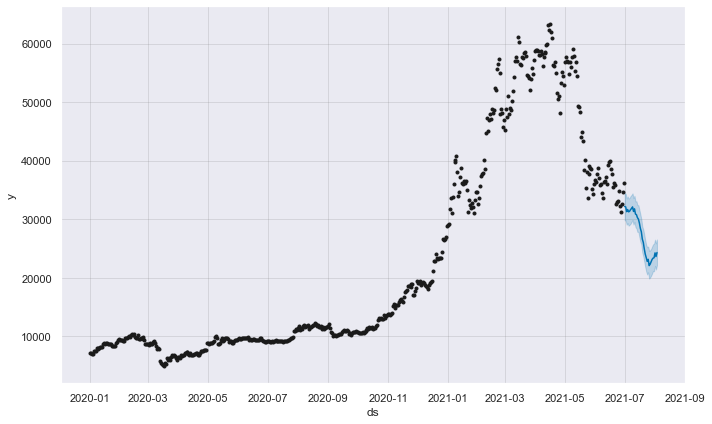

In [38]:
open_price.plot(forecast)
plt.show()

In [41]:
test['pred'] = forecast.yhat.values
test['pred_upper'] = forecast.yhat_upper.values
test['pred_lower'] = forecast.yhat_lower.values
test.dropna(inplace=True)

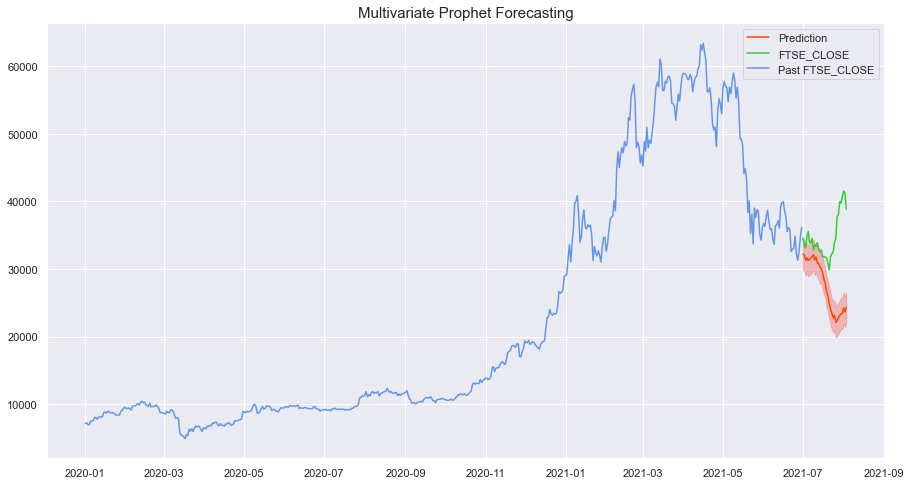

In [42]:
f, ax = plt.subplots(figsize=(15,8))

# past = train[train.ds >= '2020-11-01'].dropna()
ax.plot(test.set_index('ds')[['pred']], color = 'orangered', label='Prediction')
ax.plot(test.set_index('ds')[['y']], color = 'limegreen', label='FTSE_CLOSE')
ax.plot(train.set_index('ds')[['y']], color = 'cornflowerblue', label='Past FTSE_CLOSE')


ax.fill_between(test.ds, test.pred_lower, test.pred_upper, color='lightcoral', alpha=0.5)
# ax.fill_between(test.ds, test.low, test.high, color='lightgreen', alpha=0.5)
# ax.fill_between(past.ds, past.low, past.high, color='lightskyblue', alpha=0.5)

ax.set_title("Multivariate Prophet Forecasting", size = 15)
ax.legend()

plt.show()

### LSTM

In [9]:
import sys
import numpy as np
import pandas as pd
import pickle as pkl

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [10]:
# convert series to supervised learning
def series_to_supervised(data, column_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in column_names]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
#         print("This should not be happening")
        cols.append(df.shift(-i))
#         print(cols)
        if i == 0:
            names += [('{}(t)'.format(j)) for j in column_names]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in column_names]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [11]:
predict_date = df[df.index >= '2021-07-01']

In [12]:
predict_date.shape[0]

34

In [13]:
supervised_df = series_to_supervised(df, column_names=df.columns, n_in=120, n_out=predict_date.shape[0], dropnan=True)

In [14]:
values = supervised_df[supervised_df.filter(regex=('t-')).columns]
target_values = supervised_df.drop(columns=supervised_df.filter(regex=('t-')).columns)
target_values = target_values.values
values = values.values

scaler_target = MinMaxScaler(feature_range=(-1 ,1))
scaled_target = scaler_target.fit_transform(target_values)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print("Splitting data into train, validation, test")
train_X, train_y = scaled[:int(len(values)*0.60)], scaled_target[:int(len(values)*0.60)]
valid_X, valid_y = scaled[int(len(values)*0.60):int(len(values)*0.85), :], scaled_target[int(len(values)*0.60):int(len(values)*0.85), :]
test_X, test_y = scaled[int(len(values)*0.85):, :], scaled_target[int(len(values)*0.85):, :]

ncols = len(df.columns)
print("{} input columns identified".format(ncols))

Splitting data into train, validation, test
9 input columns identified


In [15]:
train_X = train_X.reshape((train_X.shape[0], int(train_X.shape[1]/ncols), ncols))
valid_X = valid_X.reshape((valid_X.shape[0], int(valid_X.shape[1]/ncols), ncols))
test_X = test_X.reshape((test_X.shape[0], int(test_X.shape[1]/ncols), ncols))

In [43]:
print("Starting network design")

# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(test_y.shape[1]))
adm = Adam(decay=0.2, learning_rate=0.001)
ndm = Nadam(schedule_decay=0.1, learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=ndm)

print("Network designed and compiled")
print(model.summary())

Starting network design
Network designed and compiled
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 120, 64)           18944     
_________________________________________________________________
lstm_7 (LSTM)                (None, 120, 32)           12416     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________


In [44]:
# fit network
print("Starting training")
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(valid_X, valid_y), verbose=1, shuffle=False)
print("Training finished")

Starting training
Epoch 1/100
4/4 [==============================] - 1s 184ms/step - loss: 0.5033 - val_loss: 0.4530
Epoch 2/100
4/4 [==============================] - 0s 50ms/step - loss: 0.4889 - val_loss: 0.4551
Epoch 3/100
4/4 [==============================] - 0s 50ms/step - loss: 0.4555 - val_loss: 0.4578
Epoch 4/100
4/4 [==============================] - 0s 50ms/step - loss: 0.4042 - val_loss: 0.4610
Epoch 5/100
4/4 [==============================] - 0s 50ms/step - loss: 0.3405 - val_loss: 0.4647
Epoch 6/100
4/4 [==============================] - 0s 51ms/step - loss: 0.2806 - val_loss: 0.4673
Epoch 7/100
4/4 [==============================] - 0s 50ms/step - loss: 0.2306 - val_loss: 0.4689
Epoch 8/100
4/4 [==============================] - 0s 50ms/step - loss: 0.1983 - val_loss: 0.4700
Epoch 9/100
4/4 [==============================] - 0s 50ms/step - loss: 0.1800 - val_loss: 0.4708
Epoch 10/100
4/4 [==============================] - 0s 50ms/step - loss: 0.1638 - val_loss: 0.4712


In [45]:
# acc = history.history
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


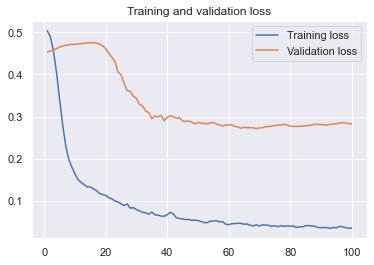

In [46]:
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
predictions = model.predict(test_X)
predictions.shape

(65, 306)

In [48]:
def transform_predictions(pred_df, cols, scaler, n_days_future=30):
    pred_df = pred_df.reshape(-1, len(cols) * n_days_future)

    # np array to df
    denormalized = scaler.inverse_transform(pred_df)
    pred_df = denormalized.reshape((n_days_future, len(cols)))
    pred_df = pd.DataFrame(pred_df, columns=cols)

    return pred_df

In [49]:
preds = transform_predictions(predictions[0], df.columns, scaler_target, n_days_future=predict_date.shape[0])['open']
tests = transform_predictions(test_y[1], df.columns, scaler_target, n_days_future=predict_date.shape[0])['open']

testing = df[['open','high', 'low']][-predict_date.shape[0]:]
testing['pred'] = preds.values

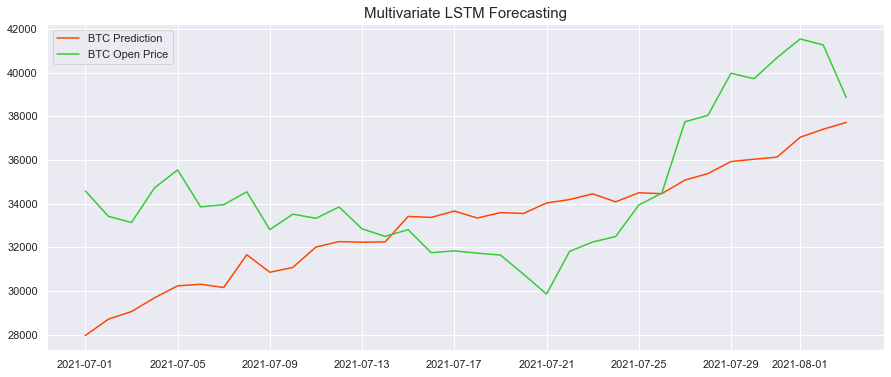

In [55]:
f, ax = plt.subplots(figsize=(15,6))

# past = df[(df.index >= "2020-11-01") & (df.index < "2020-12-01")][['ftseclose', 'ftsehigh', 'ftselow']]
ax.plot(testing[['pred']], color = 'orangered', label='BTC Prediction')
ax.plot(testing[['open']], color = 'limegreen', label='BTC Open Price')

ax.set_title("Multivariate LSTM Forecasting", size = 15)
ax.legend()

plt.show()

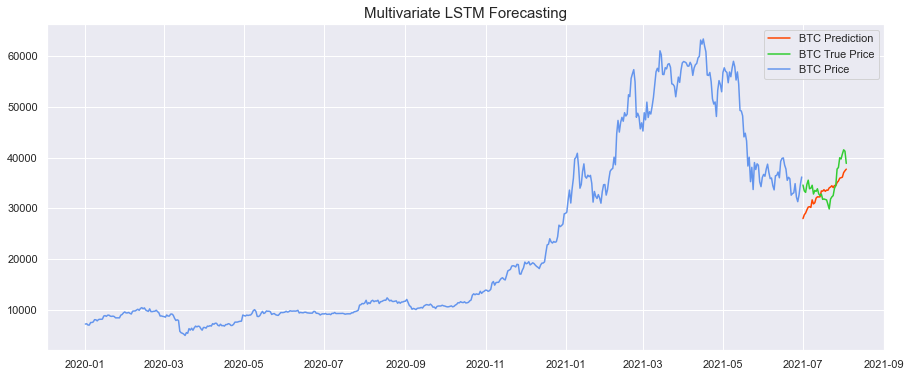

In [54]:
f, ax = plt.subplots(figsize=(15,6))

# past = df[(df.index >= "2020-11-01") & (df.index < "2020-12-01")][['ftseclose', 'ftsehigh', 'ftselow']]
ax.plot(testing[['pred']], color = 'orangered', label='BTC Prediction')
ax.plot(testing[['open']], color = 'limegreen', label='BTC True Price')
ax.plot(df[df.index < '2021-07-01'][['open']], color = 'cornflowerblue', label='BTC Price')


# ax.fill_between(test.ds, test.pred_lower, test.pred_upper, color='lightcoral', alpha=0.5)
# ax.fill_between(testing.index, testing.low, testing.high, color='lightgreen', alpha=0.5)
# ax.fill_between(past.index, past.ftselow, past.ftsehigh, color='lightskyblue', alpha=0.5)

ax.set_title("Multivariate LSTM Forecasting", size = 15)
ax.legend()

plt.show()